In [3]:
pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 37.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095458 sha256=4d76e698464ca1a1dea8555616d9510a36d9b494e7dea7d66a134278b102417f
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [4]:
import pandas as pd
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
import numpy as np
import time

df = pd.read_csv('Clean_whiskey_data.csv')
df.shape

(37223, 6)

In [5]:
pd.options.display.max_colwidth = 10000
df.sample(n=3)

,whiskey,rating,url,User_ID,Whiskey_ID,price_euros
24337,glenrothes-2011-sv,85,https://www.whiskybase.com/whiskies/whisky/217267/glenrothes-2011-sv,1123.0,1815.0,60.00
13047,chichibu-the-peated,88,https://www.whiskybase.com/whiskies/whisky/206450/chichibu-the-peated,1520.0,1025.0,343.27
23456,glengoyne-2011,91,https://www.whiskybase.com/whiskies/whisky/215752/glengoyne-2011,968.0,1744.0,120.00


In [6]:
df['whiskey'] = df['whiskey'].str.replace('-', ' ').str.title()
rec_df = df.drop(columns = ['url', 'price_euros'])
rec_df = rec_df[['User_ID', 'Whiskey_ID', 'rating']]
rec_match = df[['url', 'whiskey', 'Whiskey_ID', 'price_euros']].drop_duplicates('Whiskey_ID')
rec_match.head()

,url,whiskey,Whiskey_ID,price_euros
0,https://www.whiskybase.com/whiskies/whisky/218272/1770-2015-glasgow-single-malt,1770 2015 Glasgow Single Malt,0.0,85.14
17,https://www.whiskybase.com/whiskies/whisky/220758/1770-2016-glasgow-single-malt,1770 2016 Glasgow Single Malt,1.0,89.44
37,https://www.whiskybase.com/whiskies/whisky/205065/1770-2017,1770 2017,2.0,160.02
45,https://www.whiskybase.com/whiskies/whisky/217751/1770-2018,1770 2018,3.0,75.76
61,https://www.whiskybase.com/whiskies/whisky/220759/1770-2018-glasgow-single-malt,1770 2018 Glasgow Single Malt,4.0,83.88


In [ ]:
rec_df.User_ID.max()

2377.0

Checking RMSE 

In [7]:
from surprise import Reader, Dataset
reader = Reader(rating_scale = (1,100))
data = Dataset.load_from_df(rec_df,reader)
from surprise.model_selection import train_test_split
from surprise import accuracy
trainset, testset = train_test_split(data, test_size=0.25, random_state = 100)
svd = SVD()
svd.fit(trainset)
preds = svd.test(testset)
accuracy.rmse(preds)

RMSE: 2.7449


2.7448678591366433

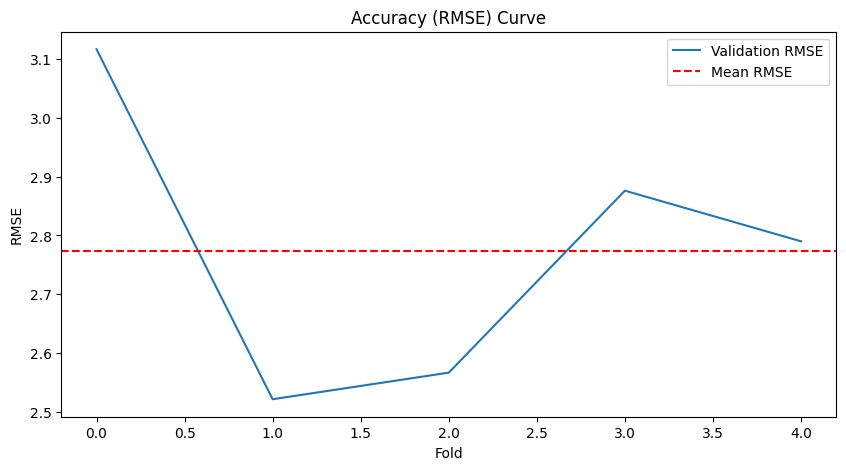

In [ ]:
import matplotlib.pyplot as plt

# Add a custom function to perform cross-validation
def custom_cross_validate(algo, data, measures=['rmse'], cv=5, verbose=True):
    from surprise.model_selection import KFold
    kf = KFold(n_splits=cv)
    
    rmse_values = []
    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        predictions = algo.test(testset)
        rmse = accuracy.rmse(predictions, verbose=False)
        rmse_values.append(rmse)
    
    mean_rmse = np.mean(rmse_values)
    return rmse_values, mean_rmse

# Set up the SVD algorithm with a specific number of epochs
algo = SVD(n_epochs=100, verbose=False)

# Perform custom cross-validation
rmse_values, mean_rmse = custom_cross_validate(algo, data, measures=['rmse'], cv=5)

# Plot accuracy (RMSE) curve
plt.figure(figsize=(10, 5))
plt.plot(rmse_values, label="Validation RMSE")
plt.axhline(y=mean_rmse, color='r', linestyle='--', label="Mean RMSE")
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.title("Accuracy (RMSE) Curve")
plt.legend()
plt.show()

The SVD model in Surprise has two main components: the user factors matrix (P) and the item factors matrix (Q). Number of factors (default is 100) used in the SVD model.

In [8]:
# Fit the SVD model
svd = SVD()
svd.fit(trainset)

# Get the user factors matrix (P) and item factors matrix (Q)
P = svd.pu
Q = svd.qi

# Print the shapes of P and Q
print("User factors matrix (P) shape:", P.shape)
print("Item factors matrix (Q) shape:", Q.shape)

User factors matrix (P) shape: (2329, 100)
Item factors matrix (Q) shape: (2590, 100)


In [ ]:
def test_pal(uid, iid, actual):
    pred = svd.predict(uid, iid, actual, verbose=True)
    match = rec_match.loc[rec_match['Whiskey_ID'] == iid]
    return match

test_pal(601,0, 90)

user: 601        item: 0          r_ui = 90.00   est = 87.48   {'was_impossible': False}


,url,whiskey,Whiskey_ID,price_euros
0,https://www.whiskybase.com/whiskies/whisky/218272/1770-2015-glasgow-single-malt,1770 2015 Glasgow Single Malt,0.0,85.14


In [ ]:
!pip install IPython

In [16]:
from IPython.display import Image, display

def find_booze(user_ratings, num_recs, priceEUR):
    new_ratings_df = pd.concat([rec_match, pd.DataFrame(user_ratings)], ignore_index=True)
    new_ratings_df = new_ratings_df[new_ratings_df['price_euros'] < priceEUR]
    new_ratings_df = new_ratings_df.drop(columns=['url', 'whiskey', 'price_euros'])

    #load in new df
    new_data = Dataset.load_from_df(new_ratings_df,reader)
    #new svd object
    svd_new = SVD()
    #refit the model
    svd_new.fit(new_data.build_full_trainset())

    # predictions
    list_of_whiskies = []
    for w_id in new_ratings_df['Whiskey_ID'].unique():
        list_of_whiskies.append((w_id, svd_new.predict(new_ratings_df['User_ID'].max(),w_id)[3]))

    # sort results from highest to lowest rated
    sorted_list = sorted(list_of_whiskies, key=lambda x:x[1],reverse=True)

    rec_num = 1
    for i in sorted_list[:num_recs]:
        found_booze = rec_match[rec_match['Whiskey_ID'] == i[0]]
        print('Offer number:', rec_num)
        print('Whiskey: ' + found_booze.values[0][1])
        print('Average Price: ' + str(found_booze.values[0][-1]))
        print('URL: ' + found_booze.values[0][0])
        
        # Display a small image preview
        image_url = found_booze.values[0][0] + '/mini'
        display(Image(url=image_url, width=200, height=200))
        
        print('\n')
        rec_num += 1

def BoozePal(df, num):
    userID = rec_df.User_ID.max()+1
    num_recs = input('How many offers you need ? Enter a number from 1 to 10:\n')
    
    while int(num_recs) > 10:
        num_recs = input('You entered a number over 10. Please enter a number from 1 to 10 to continue. \n')
    priceEUR = input('Enter your budget for a bottle. EUR ')
    rating_list = []
    
    while num > 0:
        whiskey = df[df['price_euros'] < int(priceEUR)].sample(1)
        print('\nPlease rate the following {} whiskies. \n'.format(num))
        print('Whiskey: ' + whiskey.values[0][0])
        print('Price: ' + str(whiskey.values[0][-1]))
        print('URL: ' + whiskey.values[0][2])
        rating = input('Rate this whiskey from 1 to 100, press n if you do not know it. :\n')
            
        if rating == 'n':
            continue
        if int(rating) > 100:
            print('Rating must be below 100!')
            continue
        else:
            rating_one_whiskey = {'User_ID':userID,'Whiskey_ID': whiskey['Whiskey_ID'].values[0],'rating': rating}
            rating_list.append(rating_one_whiskey) 
            num -= 1
        time.sleep(1.5)
    print('\n'+'BoozePal offers : '+'\n')
    
    time.sleep(1.5)
    find_booze(rating_list, int(num_recs), int(priceEUR))

In [17]:
BoozePal(df, 3)

How many offers you need ? Enter a number from 1 to 10:
2
Enter your budget for a bottle. EUR 200

Please rate the following 3 whiskies. 

Whiskey: Lagavulin 07 Year Old
Price: 194.36
URL: https://www.whiskybase.com/whiskies/whisky/218869/lagavulin-07-year-old
Rate this whiskey from 1 to 100, press n if you do not know it. :
80

Please rate the following 2 whiskies. 

Whiskey: Balcones Eclipse
Price: 84.49
URL: https://www.whiskybase.com/whiskies/whisky/225296/balcones-eclipse
Rate this whiskey from 1 to 100, press n if you do not know it. :
45

Please rate the following 1 whiskies. 

Whiskey: Balvenie 12 Year Old
Price: 35.78
URL: https://www.whiskybase.com/whiskies/whisky/209243/balvenie-12-year-old
Rate this whiskey from 1 to 100, press n if you do not know it. :
90

BoozePal offers : 

Offer number: 1
Whiskey: 1770 2015 Glasgow Single Malt
Average Price: 85.14
URL: https://www.whiskybase.com/whiskies/whisky/218272/1770-2015-glasgow-single-malt




Offer number: 2
Whiskey: 1770 2016 Glasgow Single Malt
Average Price: 89.44
URL: https://www.whiskybase.com/whiskies/whisky/220758/1770-2016-glasgow-single-malt
